# Training Materials: Dam Water Level Change Detection with ALOS-2

**Overall Goal:** To equip participants with the skills to detect changes in dam water levels using ALOS-2 satellite data, incorporating slope analysis for mountainous terrain.

## Module 1: ALOS-2 for Water Level Change Detection

### 1.1 ALOS-2 Data Applications
- Focus on disaster monitoring and hydrology/water resource management.
### 1.2 Why use ALOS-2 for Dam Water Level Change Detection? 
- Highlighting the benefits of SAR for water detection.
### 1.3 Case Study: Yamba Dam, Japan 
- Introduce the case study area and the specific problem.

## Module 2: Change Detection using Normal Distribution

### 2.1 Introduction to Normal Distribution
The normal distribution is a probability distribution characterized by its mean and standard deviation. It's often used to model natural phenomena.

### 2.2 Detecting Significant Changes in Difference Images

This section presents a procedure for detecting areas of water body change by considering 2.5% ($\mu \pm 2\sigma$) on each side of the pixel value distribution as a significant change.

##### Calculate threshold by mean and standard deviation

Calculate the pixel value mean (`mean_diff`) and standard deviation (`std_diff`) of the difference images.

In the following cells:
- lower_bound and upper_bound with μ±2σ.
- Pixels within `[lower_bound, upper_bound]` are considered “no change” and pixels outside this range [`< lower_bound` or `> upper_bound`] are considered “changed”.
- This method follows the assumption of a normal distribution and assumes that most pixels within ±2σ represent no change.

**Note:** In this material, `diff_image` (the output of calculate difference between 2 images) represents the pixel-by-pixel difference between pre-typhoon and post-typhoon images.

In [1]:
pip install rasterio

  Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached rasterio-1.4.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopandas

  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached geopandas-1.0.1-py3-none-any.whl (323 kB)
Using cached pyogrio-0.10.0-cp311-cp311-manylinux_2_28_x86_64.whl (24.1 MB)
Using cached pyproj-3.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
Using cached shapely-2.0.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

##### Load image

In [4]:
# --- Load the Difference Image ---
difference_image_path = '/home/jovyan/shared/Arissara/genAI/pre_post_diff_img.tif'
with rasterio.open(difference_image_path) as src:
    diff_image = src.read(1)  # Read the first band
    profile = src.profile  # Get profile for saving output

##### Compute the Mean and Standard Deviation

Calculate the mean (`mean_diff`) and standard deviation (`std_diff`) of the `diff_image` data.

In [5]:
# --- Compute Mean (μ) and Standard Deviation (σ) ---
mean_diff = np.mean(diff_image)
std_diff = np.std(diff_image)

##### Define μ ± 2σ Thresholds

In [6]:
# Define threshold with μ±2σ
lower_bound = mean_diff - 2 * std_diff
upper_bound = mean_diff + 2 * std_diff

- Set the lower and upper bounds for the μ ± 2σ method.
- Pixels within the range `[lower_bound, upper_bound]` are considered "no-change", while Pixels outside this range (`< lower_bound` or `> upper_bound`) are considered "changed"
- This method assumes that most pixels within the ± 2σ range represent no change, following a normal distribution assumption.

##### Apply μ ± 2σ Threshold to Classify Changed and No-Changed Areas

Create a binary map (`changed_area`) where each pixel is labeled as "changed" or "no-change”.

In [7]:
# Apply a threshold of μ±2σ
changed_area = ((diff_image < lower_bound) | (diff_image > upper_bound)).astype(np.uint8)  # 1 for changed, 0 for no-change

##### Visualization

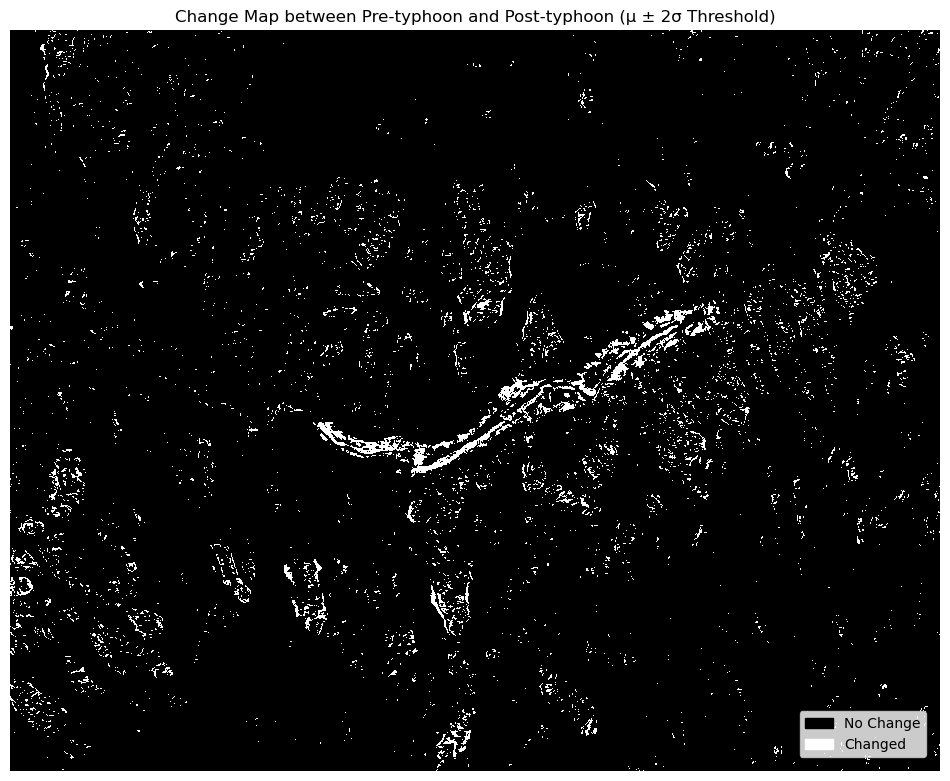

In [8]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap  # Import ListedColormap

# `changed_area` is binary change map data, where "changed" is 1 and "no change" is 0.

fig, ax = plt.subplots(figsize=(12, 12))

# Plot the results using a gray color map.
ax.imshow(changed_area, cmap=ListedColormap(['black', 'white']))
ax.set_title("Change Map between Pre-typhoon and Post-typhoon (μ ± 2σ Threshold)")
ax.axis("off")

# Create a custom legend with “no change” and “change” colors.
no_change_patch = mpatches.Patch(color="black", label="No Change")  # Black is no change
changed_patch = mpatches.Patch(color="white", label="Changed")      # White is change
plt.legend(handles=[no_change_patch, changed_patch], loc="lower right", borderaxespad=1)

# Display plot
plt.show()

Changes in the water area due to waterlogging of the dam were detected as “changed”.

Pixels that are considered “changed” are scattered not only in the dam but also in the surrounding area, but these are noise. Since the radar incidence angle (the difference between the slope angle of the terrain and the altitude angle of the satellite) affects the observed values of the synthetic aperture radar, pre-processing to compensate for this effect may be necessary. [ALOS-2/PALSAR-2 data product L2.2 performs slope gradient correction processing, but it is processed only for ScanSAR and is released free of charge](https://www.eorc.jaxa.jp/ALOS/en/dataset/palsar2_l22_e.htm), and standard products are not provided.

It is also important to exclude noise as described above by defining the region of interest in advance. For example, the shape of the water surface in a completely waterlogged condition could be stored in advance as a polygon layer in the GIS, and the change detection analysis could be processed only inside that polygon. It may also be useful to treat neighboring pixels as clusters and consider clusters smaller than a certain size as noise.

##### Save the Change Map as a GeoTIFF

In [38]:
# Define output file path
output_change_map_path = '/home/jovyan/shared/Arissara/genAI/output/change_map.tif'

# Update profile for saving the binary raster
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')  # uint8 for binary data

# Write the change map to a GeoTIFF
with rasterio.open(output_change_map_path, 'w', **profile) as dst:
    dst.write(changed_area, 1)  # Write to the first band

print(f"Change map saved at: {output_change_map_path}")

Change map saved at: /home/jovyan/shared/Arissara/genAI/output/change_map_Yamba.tif


## Module 3: Raster to Vector Conversion (Optional)
- Converting the raster water mask to a vector polygon.

In [35]:
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape
import numpy as np

In [36]:
# Path to the input raster file
input_raster = '/home/jovyan/shared/Arissara/genAI/output/change_map.tif'
output_vector = '/home/jovyan/shared/Arissara/genAI/output/change_map.gpkg'  # You can change to .geojson or .gpkg

In [37]:
# Open the raster file using rasterio
with rasterio.open(input_raster) as src:
    # Read the first band (or all bands depending on your needs)
    raster = src.read(1)
    
    # Get the affine transform to preserve the spatial coordinates
    transform = src.transform
    
    # Get the coordinate reference system (CRS)
    crs = src.crs

# Optional: Threshold the raster (e.g., binary mask)
# This is only required if you want to extract certain areas based on the raster values
binary_raster = raster > 0  # Example threshold, adjust based on your data

# Vectorize the raster using rasterio.features.shapes to generate polygons
results = (
    {'properties': {'value': v}, 'geometry': shape(s)}
    for s, v in shapes(binary_raster.astype(np.int16), transform=transform)
)

# Convert the result to a GeoDataFrame (which supports geospatial vector data)
geoms = list(results)
gdf = gpd.GeoDataFrame.from_features(geoms, crs=crs.to_string())  # Set CRS to match the raster

# Save the vectorized output to a file (Shapefile, GeoJSON, GPKG)
gdf.to_file(output_vector, driver="GPKG")  # You can change the format here

# Optionally, display a summary of the vector data
print(gdf.head())

                                            geometry  value
0  POLYGON ((287414.382 4051494.43, 287414.382 40...    1.0
1  POLYGON ((287521.882 4051494.43, 287521.882 40...    1.0
2  POLYGON ((287559.382 4051494.43, 287559.382 40...    1.0
3  POLYGON ((287774.382 4051494.43, 287774.382 40...    1.0
4  POLYGON ((287794.382 4051494.43, 287794.382 40...    1.0
